In [17]:
#dataset is Mental Health Client-Level Data from SAMHSA
#https://www.datafiles.samhsa.gov/dataset/mental-health-client-level-data-2021-mh-cld-2021-ds0001

In [1]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_mental_health_client-level_data.ipynb
to_do.txt


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
NUM_POINTS = 10_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [4]:
# Load data (deserialize)
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)

In [5]:
#disorder columns
#they are all 0/1 data
#these are dignoses for the disorders
#there are 13 of them
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [6]:
#make a seaborn correlation plot of disorders
#sns.pairplot(data[:1_000][disorder_cols])
#plt.show()

In [7]:
#drop columns
#(MH1, MH2, MH3) are redundant Boolean summed to get diagnosis tuple.
#YEAR = 2021, no info. CASEID are large, irrelevant.
#geographic columns ('STATEFIP','REGION','DIVISION') aren't relevant for this
drop_cols = ['YEAR','CASEID','SUB','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [8]:
data.shape

(10000, 28)

In [9]:
#transform columns to standardized 0-1 numeric
#for categories like gender map "unknown" to .5
transform_cols = ['AGE','EDUC','GENDER','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [10]:
data.head()

,AGE,EDUC,ETHNIC,RACE,GENDER,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,IJSSERVICE,...,CONDUCTFLG,DELIRDEMFLG,BIPOLARFLG,DEPRESSFLG,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG
0,0.785714,0.8,2,3,0,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
1,0.500000,0.0,3,3,1,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,0.357143,1.0,4,5,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1.000000,0.0,3,3,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,0.285714,0.8,4,5,1,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0


In [11]:
#find the categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(10000, 49)


In [21]:
#create labels for the 13 disorder features
#binary encode them since they are 0/1
#take the total number of disorders present
#create unique leabel for each disorder, plus one for no disorder and one for multiple disorders
#use k-means to automatically label the clusters
from sklearn.cluster import KMeans
def get_labels(dataset, label_type='binary_encode',num_clusters=5):
    #generate labels using k-means
    if label_type == 'k-means':
        kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, random_state=0, n_init=10)
        kmeans.fit(dataset)
        return pd.DataFrame(kmeans.labels_,columns=['label'])
    labels = []
    for row in dataset[disorder_cols][:NUM_POINTS].itertuples():
        if label_type=='binary_encode':
            #binary number encoding of disorders
            encoding = sum(row[i]*2**(i-1) for i in range(1,len(row)))
            labels.append(encoding)
        #sum the total number of disorders
        num_disorders = sum(row[i] for i in range(1,len(row)))
        if label_type == 'num_disorders':
            labels.append(num_disorders)
        #unique labels for pure disorders, separate categories for multiple or no disorders
        if label_type == 'unique_disorders':
            if num_disorders == 0:
                labels.append('no_disorder')
            if num_disorders == 1:
                #get the index (string) of the column with value 1
                labels.append(disorder_cols[list(row)[1:].index(1)])
            if num_disorders > 1:
                labels.append('multi-disorder')
    return pd.DataFrame(labels,columns=['label']) 

In [30]:
labels_kmeans = get_labels(data,label_type='k-means')

In [22]:
labels_binary_enc = get_labels(data,label_type='binary_encode')

In [24]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
#perform PCA
from sklearn import datasets, decomposition
n_samples = data.shape[0]

In [25]:
pca = decomposition.PCA(n_components=3)
pca.fit(data)
data.shape

(10000, 49)

In [27]:
#https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
# We center the data and compute the sample covariance matrix
X_centered = data - np.mean(data, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)

0.6823012426693298
0.6823694796171935
0.49218200005031004
0.49223122316225354
0.42285943427984524
0.4229017244020615


In [28]:
#create pandas dataframes from label and pca transformed data
X_transform = pca.transform(data)
pca_transform_df = pd.DataFrame(X_transform,columns=['score0','score1','score2'])

In [32]:
pca_results_labeled = labels_kmeans.merge(pca_transform_df, left_index=True, right_index=True)
pca_results_labeled.shape

(10000, 4)

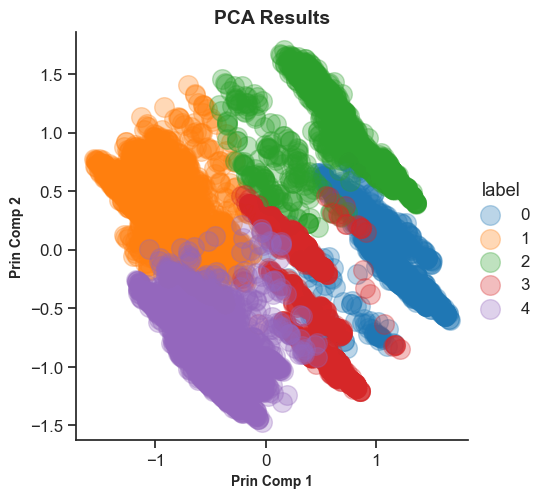

In [33]:
# Plot of PCA

# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot(x='score0',
           y='score1',
           data=pca_results_labeled,
           fit_reg=False,
           legend=True,
           #size=9,
           hue='label',
           scatter_kws={"s":200, "alpha":0.3})

plt.title('PCA Results', weight='bold').set_fontsize('14')
plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')
plt.savefig('plots/pca_mental-health_client-level.png')

In [ ]:
#PERFORM t-SNE

In [34]:
from sklearn.manifold import TSNE

In [35]:
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)

In [36]:
tsne_results = tsne.fit_transform(data)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.532700
[t-SNE] KL divergence after 300 iterations: 1.815052


In [37]:
tsne_df = pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]

In [38]:
tsne_df.shape

(10000, 2)

In [40]:
tsne_results_labeled = labels_kmeans.merge(tsne_df, left_index=True, right_index=True)

/var/folders/4d/rp7dhwss6znf18sks0v304d80000gn/T/ipykernel_2472/194326530.py:3: UserWarning: The palette list has more values (15) than needed (5), which may not be intended.
  plot = sns.scatterplot(


[Text(0.5, 1.0, 't-SNE plot with k-means labels')]

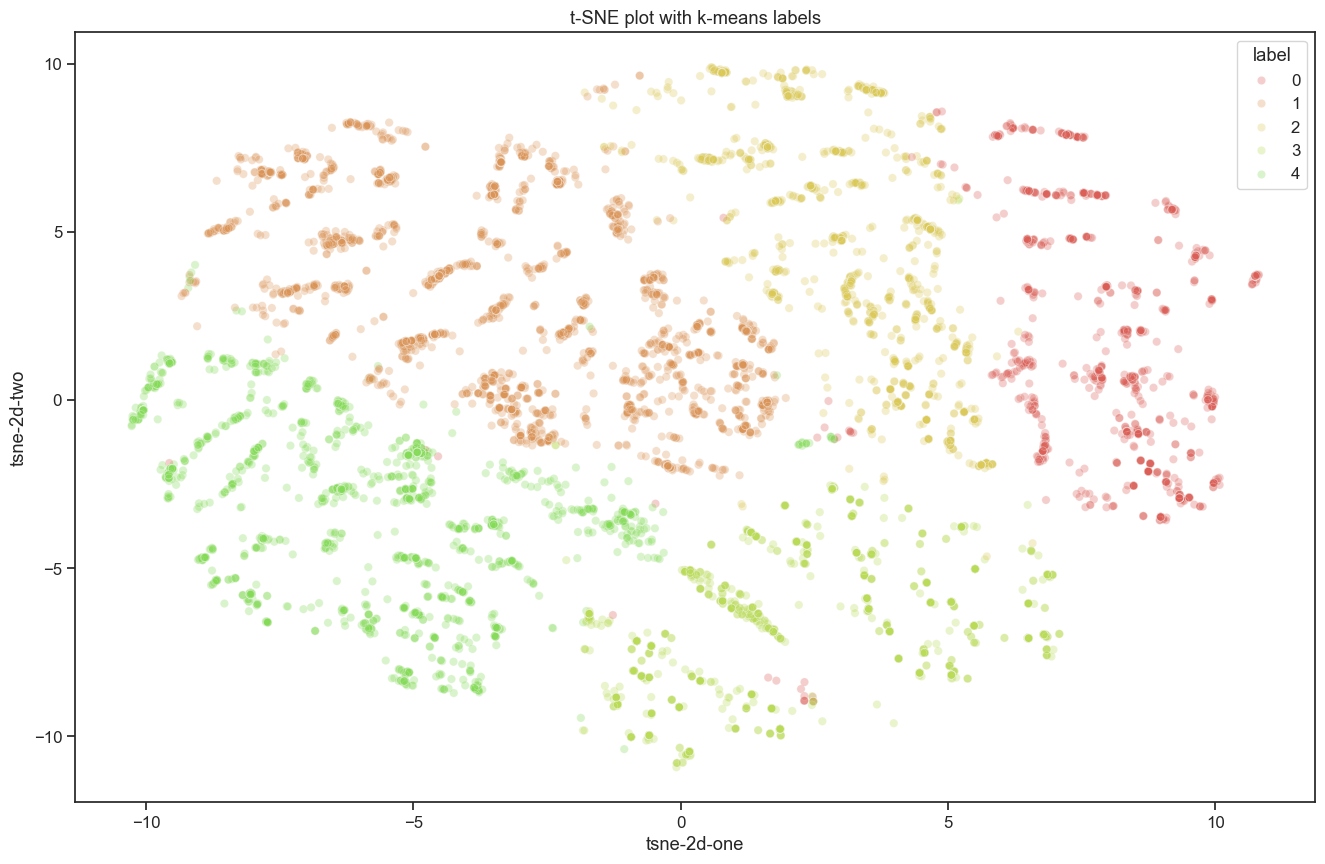

In [43]:
#plot the t-SNE results with diagnostic labels
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 15),
    data=tsne_results_labeled,
    legend="full",
    alpha=0.3
)
plot.set(title='t-SNE plot with k-means labels')

In [44]:
fig = plot.get_figure()
fig.savefig("./plots/tsne-plot_mhcld_perplexity=50_num-data-points=10_000_num-iters=300_num-cols=49_labels=k-means.png")